# Chapter 8: Debugging XGBoost

## Stress testing
A recession is a situation when there is a substantial decline in a country’s economy lasting several months. Remember the financial crisis of 2008 and, more recently, the economic slowdown caused by the COVID pandemic? We want to see how our model might perform if a recession occurs while it is deployed. In this section, we’ll simulate a recession scenario and the re-assess the performance of our constrained and regularized XGBoost model.

#### Methodology 
* change payments to be more late and lower

* decrease credit limits

* increase bill amounts

* re-evaluate performance
---

## 1. Setting the Environment
Download the [zipped **data** folder](https://github.com/ml-for-high-risk-apps-book/Machine-Learning-for-High-Risk-Applications-Book/blob/main/code/data_and_package.zip) onto your local system and save it as `Data.zip`. 

In [1]:
# Upload the downloaded zipped file from your system to the colab environment. 
from google.colab import files
uploaded = files.upload()

Saving Data.zip to Data.zip


In [2]:
!unzip -q "/content/Data.zip" 
%cd /content/Data

/content/Data


In [3]:
# Installing the libraries
%pip install h2o 
%pip install 'XGBoost==1.6'


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.5/177.5 MB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.38.0.4-py2.py3-none-any.whl size=177628739 sha256=eeb334c74b8ced5ed160005107c9cd6904245db8538d6ae0012713d7ab210236
  Stored in directory: /root/.cache/pip/wheels/6b/1d/65/39927b5984bde22f615b4c6e9a8ee98ea4abf1acb5926623ff
Successfully built h2o
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 MB 4.4 MB/s eta 0:00:00
  Attempting uninstall: XGBoost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


### Global hyperpameters

In [1]:
SEED = 12345 # global random seed for better reproducibility

### Python imports and inits

In [2]:
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators import H2OXGBoostEstimator
from h2o.grid.grid_search import H2OGridSearch
import numpy as np   # array, vector, matrix calculations
import pandas as pd  # DataFrame handling
import seaborn as sns

import matplotlib.pyplot as plt # general plotting
pd.options.display.max_columns = 999 # enable display of all columns in notebook

# display plots in-notebook
%matplotlib inline   

h2o.init(max_mem_size='4G')      # start h2o
h2o.remove_all()                 # remove any existing data structures from h2o memory
h2o.no_progress()                # turn off h2o progress indicators  

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "17.0.2" 2022-01-18 LTS; Java(TM) SE Runtime Environment (build 17.0.2+8-LTS-86); Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from /Users/jcurtis/.pyenv/versions/3.9.6/envs/hrml/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/34/wvq22l75453b0x6pk20sx7vw0000gp/T/tmp12sxqf_m
  JVM stdout: /var/folders/34/wvq22l75453b0x6pk20sx7vw0000gp/T/tmp12sxqf_m/h2o_jcurtis_started_from_python.out
  JVM stderr: /var/folders/34/wvq22l75453b0x6pk20sx7vw0000gp/T/tmp12sxqf_m/h2o_jcurtis_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,"1 year, 3 months and 5 days !!!"
H2O_cluster_name:,H2O_from_python_jcurtis_t8yg95
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


### Importing dataset 

In [4]:
data = pd.read_csv('../Data/Data/credit_line_increase.csv')
data.head()

,ID,LIMIT_BAL,SEX,RACE,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DELINQ_NEXT
0,1,20000,2,1.0,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2.0,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,3.0,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,4.0,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,3.0,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Assign target and inputs for models
Note that Demographic features are not used as model inputs.

In [5]:
data = data.rename(columns={'DELINQ_NEXT': 'DEFAULT_NEXT_MONTH'}) 

In [6]:
np.random.seed(SEED)

split_train_test = 2/3

split = np.random.rand(len(data)) < split_train_test
train = data[split].copy()
test = data[~split].copy()

split_test_valid = 1/2

split = np.random.rand(len(test)) < split_test_valid
valid = test[split].copy()
test = test[~split].copy()

#del data

print(f"Train/Validation/Test sizes: {len(train)}/{len(valid)}/{len(test)}")

Train/Validation/Test sizes: 19919/5045/5036


In [7]:
test.reset_index(inplace=True,drop=True)

In [8]:
target = 'DEFAULT_NEXT_MONTH'
demographic_cols = ['SEX', 'RACE','EDUCATION', 'MARRIAGE', 'AGE']
features = [col for col in train.columns if col not in demographic_cols + ['ID',target]]

print('target =', target)
print('predictors =', features)

target = DEFAULT_NEXT_MONTH
predictors = ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [9]:
# Converting Pandas dataframe into H2O Frame
training_frame = h2o.H2OFrame(train)
validation_frame = h2o.H2OFrame(valid)
test_frame = h2o.H2OFrame(test)

In [10]:
# Setting target column to factor so we can build classification model

training_frame[target] = training_frame[target].asfactor()
validation_frame[target] = validation_frame[target].asfactor()
test_frame[target] = test_frame[target].asfactor()

## 2. Training an H2O XGBoost model

### Setting XGBooost Parameters

Assigning monotonic constraints

In [11]:
mono_constraints = {'LIMIT_BAL': -1,
 'PAY_0': 1,
 'PAY_2': 1,
 'PAY_3': 1,
 'PAY_4': 1,
 'PAY_5': 1,
 'PAY_6': 1,
 'BILL_AMT1': -1,
 'BILL_AMT2': -1,
 'BILL_AMT3': -1,
 'BILL_AMT4': -1,
 'BILL_AMT5': -1,
 'BILL_AMT6': -1,
 'PAY_AMT1': -1,
 'PAY_AMT2': -1,
 'PAY_AMT3': -1,
 'PAY_AMT4': -1,
 'PAY_AMT5': -1,
 'PAY_AMT6': -1}


### Training XGBoost with best CV rank params

See [Selecting a Better XGBoost Model](https://github.com/ml-for-high-risk-apps-book/Machine-Learning-for-High-Risk-Applications-Book/blob/main/code/Chapter-8/Selecting%20a%20Better%20XGBoost%20Model.ipynb) for details on finding the best model

In [12]:
# Best parameters
params = {'reg_lambda': 0.005,
          'reg_alpha':0.0005,
           'min_child_weight': 1,
           'eta': 0.05,
           'booster':'gbtree',
           'sample_rate': 0.5,
           'col_sample_rate_per_tree': 0.7,
           'stopping_metric': 'auc',
           'stopping_rounds': 50,
           'max_depth': 7,
           'seed': SEED}


In [13]:
# Applying monotonic constraints
xgb_best = H2OXGBoostEstimator(**params, 
                               monotone_constraints=mono_constraints)

In [14]:
#Training H2O XGBoost model
xgb_best.train(x = features, y = target, training_frame = training_frame, validation_frame = validation_frame)

/Users/jcurtis/.pyenv/versions/hrml/lib/python3.9/site-packages/h2o/estimators/estimator_base.py:206: RuntimeWarning: early stopping is enabled but neither score_tree_interval or score_each_iteration are defined. Early stopping will not be reproducible!
  warnings.warn(mesg["message"], RuntimeWarning)
/Users/jcurtis/.pyenv/versions/hrml/lib/python3.9/site-packages/h2o/estimators/estimator_base.py:206: RuntimeWarning: Using user-provided parameter subsample instead of learn_rate."
  warnings.warn(mesg["message"], RuntimeWarning)


Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1673638721634_1


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1349923097738423
RMSE: 0.36741299619616385
LogLoss: 0.4322993651659245
Mean Per-Class Error: 0.2851157009062417
AUC: 0.7818457022497481
AUCPR: 0.5564249845212261
Gini: 0.5636914044994963

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26511283738350644: 


,,0,1,Error,Rate
0,0,13116.0,2415.0,0.1555,(2415.0/15531.0)
1,1,1848.0,2540.0,0.4211,(1848.0/4388.0)
2,Total,14964.0,4955.0,0.214,(4263.0/19919.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.265113,0.543723,224.0
1,max f2,0.160270,0.638183,312.0
2,max f0point5,0.443399,0.582820,146.0
3,max accuracy,0.443399,0.822682,146.0
4,max precision,0.933841,1.000000,0.0
5,max recall,0.062876,1.000000,393.0
6,max specificity,0.933841,1.000000,0.0
7,max absolute_mcc,0.304270,0.418079,203.0
8,max min_per_class_accuracy,0.211122,0.711030,266.0
9,max mean_per_class_accuracy,0.240409,0.714884,241.0



Gains/Lift Table: Avg response rate: 22.03 %, avg score: 23.89 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010041,0.787648,3.745026,3.745026,0.825000,0.838664,0.825000,0.838664,0.037603,0.037603,274.502621,274.502621,0.035349
1,2,0.020031,0.762136,3.421678,3.583757,0.753769,0.771884,0.789474,0.805358,0.034184,0.071787,242.167767,258.375714,0.066378
2,3,0.030022,0.728654,3.672601,3.613322,0.809045,0.748406,0.795987,0.786406,0.036691,0.108478,267.260070,261.332213,0.100622
3,4,0.040012,0.693163,3.284811,3.531297,0.723618,0.711445,0.777917,0.767689,0.032817,0.141294,228.481056,253.129729,0.129898
4,5,0.050003,0.656651,3.079510,3.441031,0.678392,0.674398,0.758032,0.749050,0.030766,0.172060,207.950990,244.103053,0.156543
5,6,0.100005,0.517209,2.921458,3.181244,0.643574,0.587918,0.700803,0.668484,0.146080,0.318140,192.145771,218.124412,0.279766
6,7,0.150008,0.373130,2.219579,2.860689,0.488956,0.441492,0.630187,0.592820,0.110985,0.429125,121.957863,186.068896,0.357977
7,8,0.200010,0.308048,1.681775,2.565961,0.370482,0.331311,0.565261,0.527443,0.084093,0.513218,68.177519,156.596051,0.401699
8,9,0.300015,0.236818,1.207779,2.113233,0.266064,0.264492,0.465529,0.439792,0.120784,0.634002,20.777893,111.323332,0.428349
9,10,0.400020,0.205663,0.920647,1.815087,0.202811,0.220208,0.399849,0.384896,0.092069,0.726071,-7.935342,81.508663,0.418171




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1371428705214792
RMSE: 0.3703280579722244
LogLoss: 0.4390627849169141
Mean Per-Class Error: 0.27723386064327615
AUC: 0.7773421829658853
AUCPR: 0.5630781133320683
Gini: 0.5546843659317706

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26490617089155244: 


,,0,1,Error,Rate
0,0,3281.0,613.0,0.1574,(613.0/3894.0)
1,1,457.0,694.0,0.397,(457.0/1151.0)
2,Total,3738.0,1307.0,0.2121,(1070.0/5045.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.264906,0.564687,216.0
1,max f2,0.162100,0.640455,306.0
2,max f0point5,0.431457,0.602810,141.0
3,max accuracy,0.434840,0.822002,140.0
4,max precision,0.907228,1.000000,0.0
5,max recall,0.053897,1.000000,397.0
6,max specificity,0.907228,1.000000,0.0
7,max absolute_mcc,0.308936,0.440608,192.0
8,max min_per_class_accuracy,0.215555,0.708949,257.0
9,max mean_per_class_accuracy,0.264906,0.722766,216.0



Gains/Lift Table: Avg response rate: 22.81 %, avg score: 24.46 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010109,0.798655,3.351817,3.351817,0.764706,0.852565,0.764706,0.852565,0.033884,0.033884,235.181683,235.181683,0.030802
1,2,0.020218,0.765455,3.437761,3.394789,0.784314,0.775872,0.774510,0.814219,0.034752,0.068636,243.776086,239.478885,0.062729
2,3,0.030129,0.744807,3.418853,3.402705,0.780000,0.756943,0.776316,0.795378,0.033884,0.102520,241.885317,240.270474,0.093788
3,4,0.040040,0.714075,3.243527,3.363304,0.740000,0.729961,0.767327,0.779186,0.032146,0.134666,224.352737,236.330440,0.122596
4,5,0.050149,0.677397,3.351817,3.360989,0.764706,0.696367,0.766798,0.762491,0.033884,0.168549,235.181683,236.098873,0.153398
5,6,0.100099,0.537578,2.956884,3.159336,0.674603,0.607049,0.720792,0.684924,0.147698,0.316247,195.688359,215.933626,0.280037
6,7,0.150050,0.396661,2.348113,2.889286,0.535714,0.463962,0.659181,0.611367,0.117289,0.433536,134.811344,188.928587,0.367280
7,8,0.201189,0.319286,1.715882,2.591022,0.391473,0.343901,0.591133,0.543381,0.087750,0.521286,71.588238,159.102173,0.414712
8,9,0.300099,0.244081,1.141902,2.113405,0.260521,0.272396,0.482166,0.454067,0.112945,0.634231,14.190153,111.340549,0.432896
9,10,0.400000,0.210902,0.852278,1.798436,0.194444,0.227257,0.410307,0.397420,0.085143,0.719374,-14.772179,79.843614,0.413776




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2023-01-13 11:40:21,0.099 sec,0.0,0.500000,0.693147,0.500000,0.220292,1.000000,0.779708,0.500000,0.693147,0.500000,0.228147,1.000000,0.771853
1,,2023-01-13 11:40:21,0.375 sec,1.0,0.488680,0.670753,0.758595,0.535455,3.724657,0.199408,0.488795,0.670977,0.754824,0.547364,3.558082,0.198216
2,,2023-01-13 11:40:21,0.524 sec,2.0,0.479136,0.652220,0.768712,0.540340,3.731932,0.214017,0.479568,0.653050,0.761392,0.544192,3.409113,0.201982
3,,2023-01-13 11:40:21,0.684 sec,3.0,0.469222,0.633266,0.773365,0.548598,3.745026,0.215021,0.469708,0.634185,0.768950,0.556709,3.417367,0.201189
4,,2023-01-13 11:40:21,0.784 sec,4.0,0.460165,0.616175,0.775148,0.551445,3.746128,0.219138,0.460752,0.617271,0.771374,0.559928,3.343077,0.198612
5,,2023-01-13 11:40:22,0.887 sec,5.0,0.451837,0.600611,0.775913,0.552735,3.734709,0.209800,0.452450,0.601742,0.772820,0.562937,3.437761,0.210505
6,,2023-01-13 11:40:22,0.979 sec,6.0,0.445090,0.588066,0.777352,0.553095,3.738351,0.213766,0.445893,0.589533,0.774061,0.561471,3.455941,0.207532
7,,2023-01-13 11:40:22,1.078 sec,7.0,0.438094,0.575131,0.777707,0.554183,3.699632,0.213615,0.438936,0.576659,0.775433,0.564540,3.473436,0.214866
8,,2023-01-13 11:40:22,1.168 sec,8.0,0.431733,0.563402,0.777497,0.553772,3.699632,0.217431,0.432593,0.564956,0.776093,0.565340,3.351817,0.214866
9,,2023-01-13 11:40:22,1.249 sec,9.0,0.425901,0.552641,0.777412,0.554039,3.722329,0.217481,0.426824,0.554306,0.775808,0.565280,3.390735,0.195837



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,PAY_0,9661.238281,1.000000,0.480498
1,PAY_2,2768.796387,0.286588,0.137705
2,PAY_3,1473.559326,0.152523,0.073287
3,LIMIT_BAL,891.407776,0.092266,0.044334
4,PAY_5,874.357117,0.090502,0.043486
5,PAY_AMT2,714.033875,0.073907,0.035512
6,PAY_AMT3,616.708435,0.063833,0.030672
7,PAY_AMT1,613.272400,0.063478,0.030501
8,PAY_4,470.738159,0.048724,0.023412
9,BILL_AMT1,434.976349,0.045023,0.021633


### Compare model performance

In [15]:
# print AUC
print('XGB Train AUC = %.4f' % xgb_best.auc(train=True))
print('XGB Valid AUC = %.4f' % xgb_best.auc(valid=True))


XGB Train AUC = 0.7818
XGB Valid AUC = 0.7773


### Performance on Test set

While validation dataset results look promising, a more honest estimate of the model performance would be to test it on a held-out test dataset

In [16]:
perf_test = xgb_best.model_performance(test_data=test_frame)
perf_test.auc()

0.7772799087636132

### Plotting ROC curves for training, validation and simulated test dataset before Stress testing

In [17]:
perf_train = xgb_best.model_performance(train=True)
perf_valid = xgb_best.model_performance(valid=True)
perf_test = xgb_best.model_performance(test_data=test_frame)



x = perf_train.plot(type = 'roc',plot=False);
y = perf_valid.plot(type = 'roc',plot=False);
z = perf_test.plot(type = 'roc',plot=False);

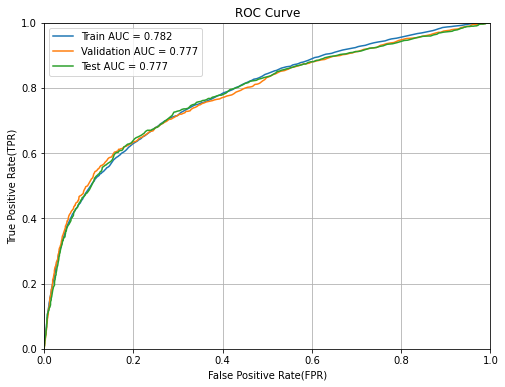

In [18]:
plt.figure(figsize=(8,6))
plt.plot(x[0],x[1],label=f'Train AUC = {np.round(xgb_best.model_performance(train=True).auc(),3)}')
plt.plot(y[0],y[1],label=f'Validation AUC = {np.round(xgb_best.model_performance(valid=True).auc(),3)}')
plt.plot(z[0],z[1],label=f'Test AUC = {np.round(xgb_best.model_performance(test_data = test_frame).auc(),3)}')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.grid()

## 3. Simulating a test set with recession conditions

We'll now alter the existing test set to represent some adverse scenarios, like recession. For that we'll start by creating a copy of the test set

In [55]:
# Creating a copy of the dataset
data_recession = test.copy(deep=True)
data_recession.head()

,ID,LIMIT_BAL,SEX,RACE,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
0,1,20000,2,1.0,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,7,500000,1,4.0,1,2,29,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
2,11,200000,2,3.0,3,2,34,0,0,2,0,0,-1,11073,9787,5535,2513,1828,3731,2306,12,50,300,3738,66,0
3,20,180000,2,3.0,1,2,29,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0
4,27,60000,1,2.0,1,2,27,1,-2,-1,-1,-1,-1,-109,-425,259,-57,127,-189,0,1000,0,500,0,1000,1


Next, we'll select 25 percent of the people who are not defaulting and will apply the modification to that subset only.

In [56]:
data_recession1 = data_recession[data_recession['DEFAULT_NEXT_MONTH'] == 0].sample(frac = .25)
data_recession1.shape

(985, 26)

In [57]:
# Rest of the dataset
data_recession2 = data_recession[~data_recession.loc[:,'ID'].isin(data_recession1['ID'])]

Next we will alter some of the feature values in the test set so that it mimics a dataset that would be seen in case of a recession. Some notable aspects of a recession are increased unemployment, negative economic growth, loan and mortgage defaults, decreased credit limits for new customers, increased consumer debt, etc.

### 1. Change payments to be more late 
We will assume that a proportion of the dataset falls behind on payments.

In [58]:
payments = ['PAY_0','PAY_2']
data_recession1[payments] += 1

### 2. Change payments to be more lower

Next, we'll decreasing the payments of the customers by 1000 dollars each.

In [59]:
pay_amounts = ['PAY_AMT1','PAY_AMT2']
data_recession1[pay_amounts] = np.where(data_recession1[pay_amounts] < 1000, 
                                        0, data_recession1[pay_amounts]-1000)

### 3. Decrease the credit limits 
Let's also decrease the credit limits of these customers by a factor of 3/4

In [60]:
data_recession1['LIMIT_BAL'] *= 0.75

### 4. Decrease Bill Amounts
Lastly, we'll reduce bill amounts by 500 dollars to represent lower consumer spending.

In [61]:
bill_amounts = ['BILL_AMT1','BILL_AMT2']
data_recession1[bill_amounts] *= 0.75

### 5. Randomly upsample the customers who will default on the payment

Also, in a recession condition, there'll be a higher probability of customers to default on their payments. We'll flip 50% of these 'recession-affected' customers to default on their loans.

In [64]:
data_recession1['DEFAULT_NEXT_MONTH'] = np.where(np.random.rand(len(data_recession1)) < 0.5, 1, 0)
data_recession1['DEFAULT_NEXT_MONTH'].value_counts()

0    495
1    490
Name: DEFAULT_NEXT_MONTH, dtype: int64

## 4. Re-evaluating performance on the simulated recession test set
Now that we have simulated a dataset that in a way mimics some sort of adverse condition that our model might  encounter in the real world, it is time to looks at the performance metrics on this data.

In [65]:
# Combining the simulated dataset with the rest of the original data
data_recession = data_recession1.append(data_recession2)

In [66]:

# Converting Pandas dataframe into H2O Frame
test_frame_recession = h2o.H2OFrame(data_recession)

# Setting target column to factor so we can build classification model

test_frame_recession[target] = test_frame_recession[target].asfactor()

In [67]:
perf_test = xgb_best.model_performance(test_data=test_frame_recession)
perf_test.auc()

0.7301461589096535

## 5. Plotting ROC curves for training, validation and simulated test dataset after Stress testing

In [68]:
perf_train = xgb_best.model_performance(train=True)
perf_valid = xgb_best.model_performance(valid=True)
perf_simulated_test = xgb_best.model_performance(test_data=test_frame_recession)



x = perf_train.plot(type = 'roc',plot=False);
y = perf_valid.plot(type = 'roc',plot=False);
z = perf_simulated_test.plot(type = 'roc',plot=False);

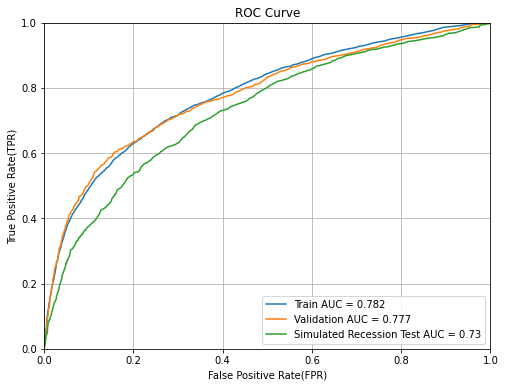

In [69]:
plt.figure(figsize=(8,6))
plt.plot(x[0],x[1],label=f'Train AUC = {np.round(xgb_best.model_performance(train=True).auc(),3)}')
plt.plot(y[0],y[1],label=f'Validation AUC = {np.round(xgb_best.model_performance(valid=True).auc(),3)}')
plt.plot(z[0],z[1],label=f'Simulated Recession Test AUC = {np.round(xgb_best.model_performance(test_data=test_frame_recession).auc(),3)}')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.grid()

Shutdown H2O Cluster

In [70]:
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)?  Y


H2O session _sid_86fd closed.
